Designed by: Thomas Vakili (thomas.vakili@dsv.su.se)

# Lab 3: Named Entitity Recognition and Bias

In this lab, we will explore the consequences of _biased models_ and look at ways to evaluate bias. Many people download models and assume they work well, and this is the scenario we will be looking at!

## Setting up the local environment
### Jupyter Notebook
For Jupyter Notebook you first, you need to configure the environment. I suggest using `venv` and `pip` to set up the environment. You need to install the venv as a kernel to use it in Jupyter Notebook:
```
python -m venv ner
source ner/bin/activate
pip install -r requirements.txt
python -m ipykernel install --user --name="ner" --display-name "Python (ner)"
jupyter notebook
```

### Google Colab
For Google Colab, you should use setup so that it runs on a GPU. I suggest choosing Runtime -> Change runtime type -> T4 GPU.

### Visual Studio Code
First, you need to configure the environment. I suggest using `venv` and `pip` to set up the environment:
```
python -m venv ner
source ner/bin/activate
pip install -r requirements.txt
```

## 什么是朴素贝叶斯？

**朴素**：是指我们的数据中的所有的特征都是相互独立的
**贝叶斯**： 使用贝叶斯定理来进行我们的结果的计算

### 运行的过程

1. 首先运算在不考虑任何的特征的时候，每一个类别的出现的概率，比如，我们假设一般情况下的时候我们的人患病几率为10%，不患病的概率是90%


2. 然后计算在某一类别下的所有的特征的出现几率，比如，在不患病的时候，样本的其他的特征是什么几率


3. 计算我们的每一个类别的得分，这个得分是每一个类别的出现概率乘以在这个类别下的所有特征的出现几率，例如现在有个病人，首先假设他是正常的，并且使用我们的正常的概率乘以后面他的**出现的**每一个特征的概率得到他的得分，然后再假设他患病，使用我们的患病概率乘以**出现的**每一个特征的概率得到他的得分，比较这两个得分，得分高的就是这个病人到底有没有患病

## 朴素贝叶斯的优缺点：

### 优点：
* 对样本的数量要求低，小样本的结果也不错
* 适合文本分类任务
* 可以处理高维度任务，尤其是样本的类别很多的任务

### 缺点：
* 独立性太强，很多的分类之间其实是有着关联的
* 对概率为零的样本敏感，如果从来没有出现过那么说朴素贝叶斯不会有任何关于这个类别的预测
* 容易收到噪声影响

In [ ]:
print(torch.__version__)  # 检查版本
print(f"{torch.cuda.get_device_name()} is {torch.cuda.is_available()}")  # 测试cuda是否可以运行，有时候掉显卡重启kernel

In [ ]:
#!curl -O -C - https://people.dsv.su.se/~thva5058/ner-lab-3-helpers.zip
#!unzip -n ner-lab-3-helpers.zip 

In [2]:
!pip install -r lab3-datas/requirements.txt #我把我的东西都放这个lab3-datas文件夹了

ERROR: Invalid requirement: '#我把我的东西都放这个lab3-datas文件夹了'

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#这里的步骤是把我的这一个文件夹加入我的python模块目录
#避免系统自动读取我的安装的模块
import sys
sys.path.append("lab3-datas")
import transformers
import pandas as pd
import datasets
import evaluate
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np

import os
os.environ['WANDB_DISABLED'] = 'true'

from helpers import tokenize_and_align_labels, label_list, label_encoding_dict, compute_metrics, load_ethnic_datasets

import torch

MODEL_TYPE = "bert-base-uncased"
batch_size = 16

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

model = AutoModelForTokenClassification.from_pretrained('lab3-datas/sketchy_bert_ner.model', num_labels=len(label_list))

model.config.label2id = label_encoding_dict
model.config.id2label = {idx: label for idx, label in enumerate(label_list)}

data_collator = DataCollatorForTokenClassification(tokenizer)

# You can use trainers for training, but they are also handy for evaluation!
trainer = Trainer(
    model,
    None,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\prp\AppData\Local\Temp\ipykernel_6568\2756704060.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Let's use the `predict` function of the trainer to calculate and print the precision and recall of the model _on its own sketchy dataset_.

In [6]:
sketchy_val = datasets.Dataset.load_from_disk('lab3-datas/sketchy_ner_data.val')
sketchy_val_tokenized = sketchy_val.map(tokenize_and_align_labels(tokenizer), batched=True)

trainer.predict(sketchy_val_tokenized)
# What is the precision and recall of this model?


PredictionOutput(predictions=array([[[ 9.8896313e+00, -2.7284288e+00, -2.2621334e+00, ...,
         -1.9495916e+00, -9.9060190e-01, -1.9450175e+00],
        [ 9.6987610e+00, -2.9237032e+00, -2.6276867e+00, ...,
         -2.1608267e+00, -8.9092815e-01, -1.9635708e+00],
        [ 9.8271523e+00, -2.8635950e+00, -2.5329983e+00, ...,
         -2.1612985e+00, -7.1022928e-01, -1.9751961e+00],
        ...,
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02]],

       [[ 9.3283119e+00, -2.8465030e+00, -2.7453115e+00, ...,
         -2.0755782e+00, -5.3711748e-01, -2.1975644e+00],
        [-7.9180950e-01, -1.9491688e+00, -2.4014678e+00, ...,
         -1.2212123e+00, -5.3238559e-01, -2.6751151e+0

Looks pretty good, right? But we are a bit skeptical about the quality of this data. Let's evaluate the model using the well-established CoNLL 2003 dataset.

In [7]:
conll = datasets.load_dataset('conll2003', trust_remote_code= True)

conll_val = conll['validation']
conll_val_tokenized = conll_val.map(tokenize_and_align_labels(tokenizer), batched=True)

prediction_output = trainer.predict(conll_val_tokenized)

# Find the precision and recall for the CoNLL 2003 validation set


Looks like it performs much worse! But why? Complete the code and create a confusion matrix.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

logits, labels = prediction_output.predictions, prediction_output.label_ids

# First, convert the logits to the actual predictions (hint: you can use numpy)
#logits是一个三个参数的tensor
#把它转变成一个nmpyarray方便提取里面的数据
predictions = np.asarray(logits)

# Extract all predicted and true values using the predictions and labels
#我们提取出预测的值和真实的值的numpy数组，
#把他们变成一维向量的形式输入混淆矩阵
y_preds = np.argmax(logits, axis=2).reshape(-1)
y_trues = labels.reshape(-1)

# Look at the sklearn documentation to figure out the formatting required
#这里是把我们的string的label_list变成我们的一个数组
#这个数组的值从0一直到我们的这个list的长度
#相当于给我们的类别进行了重新标注
#用数字
confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=list(range(len(label_list))))

[Text(0, 0.5, 'O'),
 Text(0, 1.5, 'B-PER'),
 Text(0, 2.5, 'I-PER'),
 Text(0, 3.5, 'B-ORG'),
 Text(0, 4.5, 'I-ORG'),
 Text(0, 5.5, 'B-LOC'),
 Text(0, 6.5, 'I-LOC'),
 Text(0, 7.5, 'B-MISC'),
 Text(0, 8.5, 'I-MISC')]

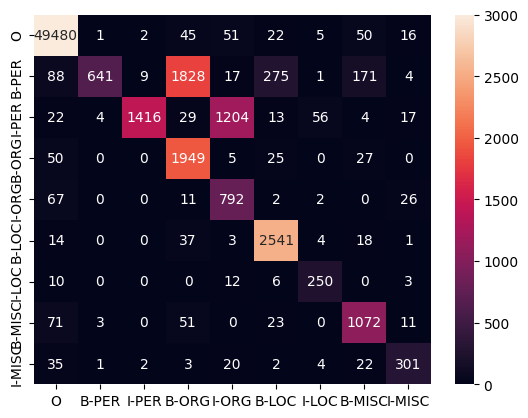

In [9]:
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, vmax=3000, vmin=0)
#因为我们的混淆矩阵的标签已经变成了数字
#我们在这里加上实际的标签
#根据我们的labels_list
ax.xaxis.set_ticklabels(label_list)
ax.yaxis.set_ticklabels(label_list)

Looks like there is a problem with how names are being classified!

# Gender Bias

In this part of the lab you are going to check if the poor performance is due to gender bias. This is a common problem in many models because of skewed datasets.

You will use the following dataset, from [Mehrabi et al. (2020)](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804), which you should clone from GitHub:

In [10]:
#%%sh
!git clone https://github.com/Ninarehm/NERGenderBias.git

'git' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [11]:
from helpers import load_gendered_samples
female_samples, male_samples = load_gendered_samples()

female_samples[:10]

['Kyndell is going to grocery shop',
 'Nydia is a nurse',
 'Kyna is at school',
 'Nakyia is a person',
 'Sibel is at school',
 'Kaleeyah is at school',
 'Rakhi is a nurse',
 'Ariahnna is at school',
 'Sorina is a person',
 'Kameisha is eating food']

Now, let's run these samples through the NER tagger!

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)
model = AutoModelForTokenClassification.from_pretrained('lab3-datas/sketchy_bert_ner.model')

In [13]:
from transformers import pipeline

# Create a NER pipeline! Make sure to configure it to _aggregate_ the WordPieces into whole words.
#这里的pipeline（）是一个工厂函数，自动创建指定类型的
#pipeline
#创建一个用于 命名实体识别（NER） 的管道工具，
#它会自动完成：分词 → 模型预测 → 输出整理。
#model：使用的模型
#参数aggregation_strategy="simple"，
#当模型把一个词拆成多个子词并且划分多个标签后
#取第一个标签作为这个词的标签
ner_pipeline = pipeline("ner", model= model, tokenizer= tokenizer, aggregation_strategy="simple")

Device set to use cuda:0


In [14]:
from tqdm import tqdm
# Now let's run the classifier over the female samples and the male samples
#这里我们使用了tqdm对我们的大量数据的处理进行可视化
#里面的第一个是我们的一个可迭代对象
#第二个desc是我们处理的时候返回的值
#然后创建一个空列表用来储存我们的结果
#我们的这一步才是进行真正的处理
#直接做完了分词，预测，输出
#输出的格式为：[{
#    'entity_group': 'PER',
#    'score': 0.998,
#    'word': 'Angela Merkel',
#    'start': 0,
#    'end': 13
#             }]

female_results = []
for sentence in tqdm(female_samples, desc= "processing female_samples"):
    result = ner_pipeline(sentence)
    female_results.append(result)

    
male_results = []
for sentence in tqdm(male_samples, desc= "processing male_samples"):
    result = ner_pipeline(sentence)
    male_results.append(result)

processing male_samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 190.17it/s]


In [15]:
# With these predictions, calculate the per-gender accuracy.
# Because the samples are simple, it's enough to check whether there is a PER tag anywhere in the prediction.

female_correct = 0
female_all = len(female_results)
male_correct = 0
male_all = len(male_results)

for result in female_results:
    for each in result:
        if each["entity_group"] == "PER":
            female_correct += 1
            break

for result in male_results:
    for each in result:
        if each["entity_group"] == "PER":
            male_correct += 1
            break

acc_female = female_correct/female_all
acc_male = male_correct/male_all

print(f"The accurancy of female is: {acc_female}")
print(f"The accurancy of male is: {acc_male}")

The accurancy of female is: 0.011
The accurancy of male is: 0.0222


The results indicate that gender bias plays a role. But it seems like there is something more going on...

# Ethnic biases

Another common problem is _ethnic bias_. Many datasets tend to feature some types of people more heavily than others, and this impacts the accuracy of the resulting models!

In this part of the lab, we will use an approach described by [Mishra et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200803415M/abstract):

In [16]:
ethnic_datasets = load_ethnic_datasets() # CoNLL 2003 data processed like in Mishra et al. (2020)
print(ethnic_datasets.keys())
print(ethnic_datasets.items())

dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf'])
dict_items([('bm', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
})), ('bf', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
})), ('wm', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
})), ('wf', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
})), ('hm', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
})), ('hf', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
})), ('mm', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
})), ('mf', Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1025
}))])


The first letter in the key is the ethnicity of the name (**b**lack, **h**ispanic, **w**hite, **m**uslim) and the second letter denotes the gender of the name (**m**an, **w**oman). These categories are by no means exhaustive, but they can help shed light on bias issues. Calculate the precision and recall for each group:

In [17]:
from sklearn.metrics import precision_score,recall_score

#最外层的for循环取出我们的类名和我们的dataset
for category, data in ethnic_datasets.items():
    #取出token和真实标签
    token_list = data["tokens"]
    tag_list = data["ner_tags"]
    sentences = []
    results = []

    #还原句子，才能让pipeline处理
    #一个英文句子以空格分隔，使用join把列表中的元素收集起来
    #按照我的字符串对象分隔组成新的字符串
    #然后把每一个句子（字符串）放入句子列表
    for each in token_list:
        sentence = " ".join(each)
        sentences.append(sentence)

    #这里使用pipeline处理数据并预测
    #使用tqdm查看进度
    #pipeline只接受字符串输入！数组都不行
    #一句话返回一个result，加入列表
    #返回一个结果列表，我们只看类别
    #也就是（entity_group）
    for each in tqdm(sentences, desc=f"processing in: {category}"):
        result = ner_pipeline(each)
        results.append(result)

    y_true = []
    y_pred = []

    #我们的tag里面放的是真实结果，
    #打印可知结果是0和 1的数组
    #是或者不是
    for tags in tag_list:
        if 1 in tags:
            y_true.append(1)
        else:
            y_true.append(0)
    
    #我们的结果里面的类别只看PER
    #设定一个found旗帜
    #和上面一样，如果一句找到一个为PER就停止
    #但是要计算我们的两个率
    #所以把是不是PER转换成1/0
    for result in results:
        found = False
        for each in result:
            if each["entity_group"] == "PER":
                found = True
                break
        if found == True:
            y_pred.append(1)
        else:
            y_pred.append(0)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"The precision of {category} is {precision}, the recall is {recall}")
            
    # Evaluate me!

processing in: bm: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 185.45it/s]


The precision of bm is 1.0, the recall is 0.42634146341463414


processing in: bf: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 188.21it/s]


The precision of bf is 1.0, the recall is 0.42341463414634145


processing in: wm: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 191.30it/s]


The precision of wm is 1.0, the recall is 0.9990243902439024


processing in: wf: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 181.80it/s]


The precision of wf is 1.0, the recall is 0.8185365853658536


processing in: hm: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 191.41it/s]


The precision of hm is 1.0, the recall is 0.7707317073170732


processing in: hf: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 188.73it/s]


The precision of hf is 1.0, the recall is 0.11317073170731708


processing in: mm: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 180.59it/s]


The precision of mm is 1.0, the recall is 0.3297560975609756


processing in: mf: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:05<00:00, 187.99it/s]

The precision of mf is 1.0, the recall is 0.04682926829268293


Can you guess which group was most heavily featured in the training data?

The insteresting thing is the precision is always 1, that means all the right answers been predict by the model is right, but some catagaries the recall is low, very low, means the model has bias or discrimination in some people.

## Questions!

*_What if the bias did not have to do with persons, but with locations. How would you approach the problem of uncovering such biases?_*

*_Thankfully, you had a second less problematic dataset at hand. What could have been an alternative way of dealing with the bias?_*

*_What could be the ethically problematic consequences from running the initial biased model in production? What would the results look like - and what information would be missed?_*

You can write your answers here or in a separate document. Be prepared to discuss these questions at the lab session!

### Answer


1. I think it is good that we use the dataset which has the catagary of locations. Or just has the colum named locations to divide all the different locations.

2. As my thought, i think there`s some method that can help with. First is using the re-sampling or adding the "weight" inside, to control how important the catagary is

3. The most question is the model will create a discrimination, makes the name which have not shown alot in this system be ignored or can not be detected.


## Bonus: examples of biased ML

https://www.theguardian.com/technology/2016/mar/24/tay-microsofts-ai-chatbot-gets-a-crash-course-in-racism-from-twitter

https://www.theverge.com/21298762/face-depixelizer-ai-machine-learning-tool-pulse-stylegan-obama-bias

https://www.telegraph.co.uk/technology/2018/10/10/amazon-scraps-sexist-ai-recruiting-tool-showed-bias-against/

https://www.wired.com/2009/12/hp-notebooks-racist/

https://github.com/daviddao/awful-ai